In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.morphology import skeletonize, remove_small_objects

#cropping the image, h-77 subtracts the title at the bottom
original_img = cv2.imread('giraffe.png',0)

(h,w)=np.shape(original_img)
img = original_img[0:h, 0:w]
plt.imshow(img, cmap = 'gray')
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

In [ ]:
#plotting histogram
plt.hist(img.ravel(),256,[0,256])
plt.show()

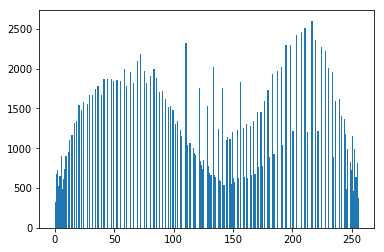

In [10]:
#equalizing the histogram
equ = cv2.equalizeHist(img)
plt.hist(equ.ravel(),256,[0,256])
plt.show()

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

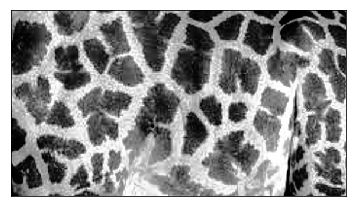

In [11]:
plt.imshow(equ, cmap='gray')
plt.xticks([]), plt.yticks([]) 

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

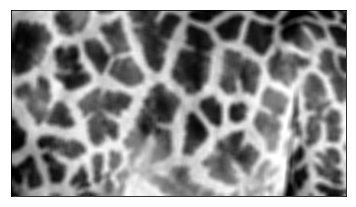

In [13]:
#blurring 
ablur = cv2.blur(equ,(10, 10))
plt.imshow(ablur, cmap='gray', interpolation='sinc')
plt.xticks([]), plt.yticks([]) 

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

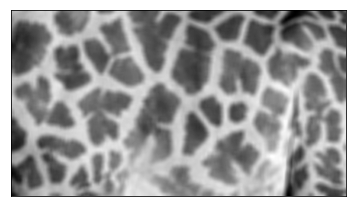

In [41]:
#blurring original
oblur = cv2.blur(img,(10, 10))
plt.imshow(oblur, cmap='gray', interpolation='sinc')
plt.xticks([]), plt.yticks([]) 

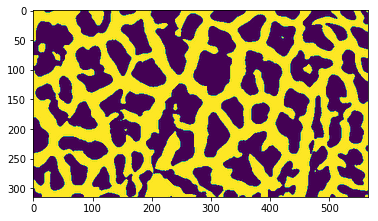

In [28]:
a_mthres = cv2.adaptiveThreshold(ablur,1,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,41,4) 
plt.imshow(a_mthres, interpolation= 'sinc')

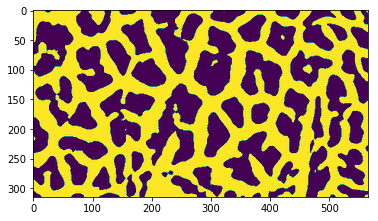

In [32]:
o_mthres = cv2.adaptiveThreshold(oblur,1,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,41,4) 
plt.imshow(o_mthres, interpolation= 'sinc')

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

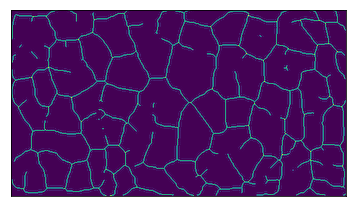

In [22]:
#This section blurs, thresholds, and skeletonizes the image
#It uses an average blur and an adaptive (local) mean threshold
#Remove_small_objects gets rid of any unconnected dots or lines
a_mthres = cv2.adaptiveThreshold(ablur,1,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,41,4) 
adaptiveskeleton = skeletonize(a_mthres)
plt.imshow(adaptiveskeleton,interpolation='sinc') 
plt.xticks([]), plt.yticks([]) 

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

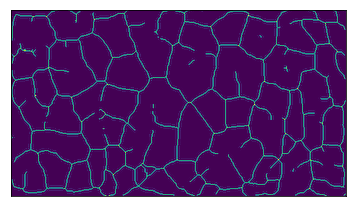

In [23]:
#without histogram equalization
o_mthres = cv2.adaptiveThreshold(oblur,1,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,41,4) 
oskel = skeletonize(o_mthres)
plt.imshow(oskel,interpolation='sinc') 
plt.xticks([]), plt.yticks([]) 

In [18]:
difference=oskel-adaptiveskeleton
plt.imshow(difference, interpolation='sinc')

TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [ ]:
#just thresholding the original image
a_mthres = cv2.adaptiveThreshold(ablur,1,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,41,4) 


In [ ]:

adaptiveskeleton = skeletonize(a_mthres)
plt.imshow(adaptiveskeleton,interpolation='sinc') 
plt.xticks([]), plt.yticks([]) 

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

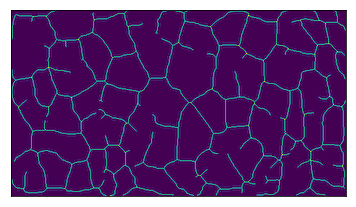

In [43]:
#cleans the skeleton by removing unnecessary unconnected dots/lines
cleanskel=remove_small_objects(adaptiveskeleton, min_size=70, connectivity=3)
plt.imshow(cleanskel,interpolation='sinc') 
plt.xticks([]), plt.yticks([]) 

In [44]:
#the original image values (integers) become floats
#Dividing by 255 normalizes the floats; now they are all between 0 and 1
floatimg=img.astype(float)
normimg=floatimg/255

#skeleton is a float, rgbpic is a RGB image with the dimensions of the cropped diatom image
#the values of R,G, and B are defined later
floatskel=cleanskel.astype(float)
(x,y)=np.shape(img)
rgbpic=np.zeros((x,y,3))

In [45]:
# this section finds the number of neighbors to each point in the skeleton
# line ends are points that have only one neighbor
# we want to get rid of these
# keep looping over this section until the number of line ends equals zero
nLineEnds = 1
while (nLineEnds>0):
    #blur the skeleton with 3x3; this gives the average value in a 3x3 portion of the skeleton
    # 9 times the average - 1 should be the number of neighbors
    skelblur = cv2.blur(floatskel,(3,3))
    neighbors=((9*skelblur)-1)

    #making sure edges always have values
    #any skeleton pixels within 'a' pixels from the edge will not be eroded
    edges=np.zeros((x,y))
    a=15
    edges[0:a,:]=np.ones((a,y))
    edges[x-a:x,:]=np.ones((a,y))
    edges[:,0:a]=np.ones((x,a))
    edges[:,y-a:y]=np.ones((x,a))
    
    #removing the end pixel if a skeleton pixel has 1 neighbor
    neighbors=(neighbors+5*edges)*floatskel
    line_ends = (neighbors==1)
    float_line_ends = line_ends.astype(float)
    floatskel=floatskel-line_ends
    nLineEnds=np.sum(line_ends)
#plt.imshow(neighbors, interpolation='sinc')

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

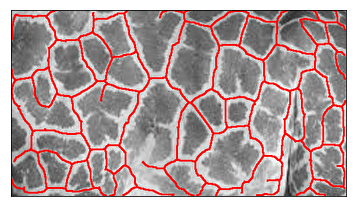

In [46]:
#dilating the lines of the skeleton to a 3x3 square of pixels (lines are bolder)
kernel=np.ones((3,3))
skel_dilation=cv2.dilate(floatskel,kernel,iterations=1)

#defining r, g, and b values for the overlay 
#if the skeleton is 1, then it plots the skeleton.
#if the skeleton is 0, it plots the grayscale image of the diatom
rgbpic[:,:,0]=skel_dilation*(1-normimg)+normimg
rgbpic[:,:,1]=(1-skel_dilation)*normimg
rgbpic[:,:,2]=(1-skel_dilation)*normimg

#plotting the overlay
plt.imshow(rgbpic, interpolation='sinc')
plt.xticks([]), plt.yticks([]) 